In [ ]:
from google.colab import drive
drive.mount("/content/drive")

%cd "/content/drive/My Drive/pa2_data"

Mounted at /content/drive
/content/drive/My Drive/pa2_data


In [ ]:
# edit -> notebook setting -> GPU
!pip install tensorflow-addons
!pip install tensorflow==2.8.2
!pip install ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 437.8 MB 33 kB/s 
     |████████████████████████████████| 5.8 MB 5.0 MB/s 
     |████████████████████████████████| 1.4 MB 47.6 MB/s 
     |████████████████████████████████| 462 kB 56.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalle

In [ ]:
# libraries
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import ffmpeg
import gzip
import random
import matplotlib.animation as animation
from matplotlib import rc
from keras.utils.layer_utils import count_params

# check versions
!python --version
print(tf.__version__)
print(tfa.__version__)

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

Python 3.7.14
2.8.2
0.18.0


Archive:  train-images-idx3-ubyte.gz
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of train-images-idx3-ubyte.gz or
        train-images-idx3-ubyte.gz.zip, and cannot find train-images-idx3-ubyte.gz.ZIP, period.
(60000, 28, 28)


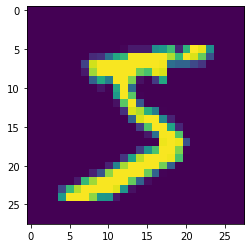

(20, 10000, 64, 64, 1)


In [ ]:
!unzip train-images-idx3-ubyte.gz

train_data = gzip.open("train-images-idx3-ubyte.gz")
train_data.read(16)
train_data = train_data.read(28*28*60000)
train_data = np.frombuffer(train_data, dtype=np.uint8).astype(np.float32)
train_data = train_data.reshape(60000, 28, 28)
train_data = tf.convert_to_tensor(train_data)

test_data = np.load("MNIST_test_seq.npy")
test_data = np.reshape(test_data, (20,-1,64,64,1))
test_data = tf.convert_to_tensor(test_data)

print(train_data.shape)
plt.imshow(train_data[0])
plt.show()

rc('animation', html='jshtml')

def get_animation(sequence):
  
  fig = plt.figure()
  frames = []
  for i in range(sequence.shape[0]):
    frame = plt.imshow(sequence[i], animated=True)
    frames.append([frame])
  ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
  plt.close(fig)

  return ani

print(test_data.shape)
ani = get_animation(test_data[:,1].reshape(20,64,64))
ani

In [ ]:
class MMNISTDataset(tf.keras.utils.Sequence):
  # C1
  def __init__(self, data_type, batchsize):
    self.data_type = data_type
    self.batchsize = batchsize
    self.mnist_train_im = train_data
    # test:valid = 8:2
    self.mnist_test = test_data[:,:8000,:,:,:]
    self.mnist_valid = test_data[:,8000:,:,:,:]
    if(data_type == "train" or data_type == "test"):
      # 8000/16 = 500
      self.length = 500
    elif(data_type == "valid"):
      # 2000/16 = 125:
      self.length = 125

  def __len__(self):
    return self.length
  
  # C2
  def gen_random_sequence(self):
    ''' randomly generate a sequence of a digit'''
    size = 64 - 28
    x, y, theta = random.random(), random.random(), random.random() * 2 * np.pi
    velocity_y, velocity_x = np.sin(theta), np.cos(theta) 
    seq_x, seq_y = np.zeros(20), np.zeros(20)

    for i in range(20):
        y += 0.1*velocity_y
        x += 0.1*velocity_x 

        if x <= 0:
            x = 0
            velocity_x = -velocity_x
        if x >= 1.0:
            x = 1.0
            velocity_x = -velocity_x
        if y <= 0:
            y = 0
            velocity_y = -velocity_y
        if y >= 1.0:
            y = 1.0
            velocity_y = -velocity_y
        seq_x[i], seq_y[i] = x, y

    # Scale to the size.
    seq_x = (size * seq_x).astype(np.int32)
    seq_y = (size * seq_y).astype(np.int32)
    return seq_y, seq_x

  def random_mmnist(self):
    ''' generate frames of moving mnist. '''
    data = np.zeros((20, 64, 64), dtype=np.float32) # 10 input + 10 groundtruth = 20
    for n in range(2):
        seq_y, seq_x = self.gen_random_sequence()
        idx = random.randint(0, self.mnist_train_im.shape[0] - 1)
        mnist_image = self.mnist_train_im[idx]
        for i in range(20):
            # put the 2 moving digits into "data"
            data[i, seq_y[i]:seq_y[i]+28, seq_x[i]:seq_x[i]+28] = np.maximum(data[i, seq_y[i]:seq_y[i]+28, seq_x[i]:seq_x[i]+28], mnist_image)
    return data
  
  # C3
  def __getitem__(self, idx):
    item = np.zeros((self.batchsize, 20, 64, 64, 1), dtype=np.float32)
    if(self.data_type == "train"):
      for i in range(self.batchsize):
        item[i] = self.random_mmnist().reshape(20,64,64,1)
    elif(self.data_type == "valid"):
      for i in range(self.batchsize):
        item[i] = self.mnist_valid[:,idx*self.batchsize + i,:,:,:]
    elif(self.data_type == "test"):
      for i in range(self.batchsize):
        item[i] = self.mnist_test[:,idx*self.batchsize + i,:,:,:]

    # normalization    
    item = item/255.0
    item = tf.convert_to_tensor(item, dtype=tf.float32)

    return item[:,:10,:,:,:], item[:,10:,:,:,:]
    

In [ ]:
train_dataset = MMNISTDataset("train", 16)
valid_dataset = MMNISTDataset("valid", 16)
test_dataset = MMNISTDataset("test", 16)

# testing __getitem__
mini_batch_x, mini_batch_y = test_dataset.__getitem__(0)
print(mini_batch_x.shape)

ani = get_animation(mini_batch_x[0].reshape(10,64,64))
ani = get_animation(mini_batch_y[0].reshape(10,64,64))

# testing normalization
print(np.max(mini_batch_x), np.min(mini_batch_x))
ani

(16, 10, 64, 64, 1)
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


In [ ]:
# C4
class Encoder(keras.layers.Layer):
  def __init__(self):
    super(Encoder, self).__init__()
    self.Enc_ConvB_1 = Enc_ConvB(kernel_size=3,stride_size=1,padding_size="same", channel_size=64)
    self.Enc_ConvB_2 = Enc_ConvB(kernel_size=3,stride_size=2,padding_size="same", channel_size=64)
    self.Enc_ConvB_3 = Enc_ConvB(kernel_size=3,stride_size=1,padding_size="same", channel_size=64)
    self.Enc_ConvB_4 = Enc_ConvB(kernel_size=3,stride_size=2,padding_size="same", channel_size=64)
  
  def call(self, inputs):
    x = tf.reshape(inputs, [-1,64,64,1])
    x = self.Enc_ConvB_1(x)
    rt1 = x
    x = self.Enc_ConvB_2(x)
    x = self.Enc_ConvB_3(x)
    x = self.Enc_ConvB_4(x)
    rt2 = x

    return rt1, rt2

# C5
class Enc_ConvB(keras.layers.Layer):
  def __init__(self, kernel_size, stride_size, padding_size, channel_size):
    super(Enc_ConvB, self).__init__()
    self.conv = keras.layers.Conv2D(strides=stride_size, kernel_size=kernel_size, padding=padding_size, filters=channel_size)
    self.norm = tfa.layers.GroupNormalization(groups=2, epsilon=1e-5)
    self.activate = keras.layers.LeakyReLU(alpha=0.2)

  def call(self, inputs):
    x = self.conv(inputs)
    x = self.norm(x)
    x = self.activate(x)

    return x
    

In [ ]:
print(mini_batch_x.shape)
encoder = Encoder()
enc_rt1, enc_rt2 = encoder(mini_batch_x)
print(enc_rt1.shape, enc_rt2.shape)
print("number of trainable weights:",count_params(encoder.trainable_weights))


(16, 10, 64, 64, 1)
(160, 64, 64, 64) (160, 16, 16, 64)
number of trainable weights: 111936


In [ ]:
# C6
class Translator(keras.layers.Layer):
  def __init__(self):
    super(Translator, self).__init__()
    self.IncepEnc_1 = Inception(256)
    self.IncepEnc_2 = Inception(256)
    self.IncepEnc_3 = Inception(256)
    self.IncepEnc_4 = Inception(256)
    self.IncepEnc_5 = Inception(256)
    self.IncepEnc_6 = Inception(256)
    self.IncepEnc_7 = Inception(256)
    self.IncepEnc_8 = Inception(256)
    self.IncepDec_1 = Inception(256)
    self.IncepDec_2 = Inception(256)
    self.IncepDec_3 = Inception(256)
    self.IncepDec_4 = Inception(256)
    self.IncepDec_5 = Inception(256)
    self.IncepDec_6 = Inception(256)
    self.IncepDec_7 = Inception(256)
    self.IncepDec_8 = Inception(640)
  
  def call(self, inputs):
    x = tf.reshape(inputs, [-1,10,16,16,64])
    x = tf.transpose(x, perm=[0,2,3,1,4])
    x = tf.reshape(x, [16,16,16,-1])

    x = self.IncepEnc_1(x)
    enc_out1 = x
    x = self.IncepEnc_2(x)
    enc_out2 = x
    x = self.IncepEnc_3(x)
    enc_out3 = x
    x = self.IncepEnc_4(x)
    enc_out4 = x
    x = self.IncepEnc_5(x)
    enc_out5 = x
    x = self.IncepEnc_6(x)
    enc_out6 = x
    x = self.IncepEnc_7(x)
    enc_out7 = x
    x = self.IncepEnc_8(x)
    x = self.IncepDec_1(x)
    x = self.IncepDec_2(tf.concat([x,enc_out7],3))
    x = self.IncepDec_3(tf.concat([x,enc_out6],3))
    x = self.IncepDec_4(tf.concat([x,enc_out5],3))
    x = self.IncepDec_5(tf.concat([x,enc_out4],3))
    x = self.IncepDec_6(tf.concat([x,enc_out3],3))
    x = self.IncepDec_7(tf.concat([x,enc_out2],3))
    x = self.IncepDec_8(tf.concat([x,enc_out1],3))

    x = tf.reshape(x, [-1,16,16,10,64])
    x = tf.transpose(x, perm=[0,3,1,2,4])

    return x

# C7
class Inception(keras.layers.Layer):
  def __init__(self, channel_size):
    super(Inception, self).__init__()
    self.Conv = keras.layers.Conv2D(strides=1, filters=128, kernel_size=1)
    self.GroupConv_1 = GroupConv(kernel_size=3, channel_size=channel_size)
    self.GroupConv_2 = GroupConv(kernel_size=5, channel_size=channel_size)
    self.GroupConv_3 = GroupConv(kernel_size=7, channel_size=channel_size)
    self.GroupConv_4 = GroupConv(kernel_size=11, channel_size=channel_size)
  
  def call(self, inputs):
    x = self.Conv(inputs)
    y1 = self.GroupConv_1(x)
    y2 = self.GroupConv_2(x)
    y3 = self.GroupConv_3(x)
    y4 = self.GroupConv_4(x)

    return y1 + y2 + y3 + y4

# C8
class GroupConv(keras.layers.Layer):
  def __init__(self, kernel_size, channel_size):
    super(GroupConv, self).__init__()
    self.conv = keras.layers.Conv2D(strides=1, kernel_size=kernel_size, padding='same', filters=channel_size, groups=8)
    self.norm = tfa.layers.GroupNormalization(groups=8, epsilon=1e-5)
    self.activate = keras.layers.LeakyReLU(alpha=0.2)

  def call(self, inputs):
    x = self.conv(inputs)
    x = self.norm(x)
    x = self.activate(x)

    return x



In [ ]:
print(enc_rt2.shape)
translator = Translator()
trans_rt = translator(enc_rt2)
print(trans_rt.shape)

(160, 16, 16, 64)
(16, 10, 16, 16, 64)


In [ ]:
# C9
class Decoder(keras.layers.Layer):
  def __init__(self):
    super(Decoder, self).__init__()
    self.Dec_ConvB_1 = Dec_ConvB(transpose=True, strides=2, padding="same", kernel_size=3, channel_size=64)
    self.Dec_ConvB_2 = Dec_ConvB(transpose=False, strides=1, padding="same", kernel_size=3, channel_size=64)
    self.Dec_ConvB_3 = Dec_ConvB(transpose=True, strides=2, padding="same", kernel_size=3, channel_size=64)
    self.Dec_ConvB_4 = Dec_ConvB(transpose=False, strides=1, padding="same", kernel_size=3, channel_size=64)
    self.Conv2d = keras.layers.Conv2D(kernel_size=1,filters=1)

  def call(self, inputs1, inputs2):
    x = tf.reshape(inputs1, [-1,16,16,64])
    
    x = self.Dec_ConvB_1(x)
    x = self.Dec_ConvB_2(x)
    x = self.Dec_ConvB_3(x)
    x = self.Dec_ConvB_4(tf.concat([x,inputs2],3))
    x = self.Conv2d(x)

    x = tf.reshape(x, [-1,10,64,64,1])

    return x

# C10
class Dec_ConvB(keras.layers.Layer):
  def __init__(self, transpose, strides, padding, kernel_size, channel_size):
    super(Dec_ConvB, self).__init__()
    self.conv = None
    if(transpose == False):
      self.conv = keras.layers.Conv2D(strides=strides, kernel_size=kernel_size, padding=padding, filters=channel_size)
    elif(transpose == True):
      self.conv = keras.layers.Conv2DTranspose(strides=strides, kernel_size=kernel_size, padding=padding, filters=channel_size, output_padding=1)
    self.norm = tfa.layers.GroupNormalization(groups=2, epsilon=1e-5)
    self.activate = keras.layers.LeakyReLU(alpha=0.2)
  
  def call(self, inputs):
    x = self.conv(inputs)
    x = self.norm(x)
    x = self.activate(x)

    return x


In [ ]:
print(trans_rt.shape, enc_rt1.shape)
decoder = Decoder()
dec_rt = decoder(trans_rt, enc_rt1)
print(dec_rt.shape)
print("number of trainable weights:",count_params(decoder.trainable_weights))

(16, 10, 16, 16, 64) (160, 64, 64, 64)
(16, 10, 64, 64, 1)
number of trainable weights: 185153


In [ ]:
class Model(keras.layers.Layer):
  def __init__(self):
    super(Model, self).__init__()
    self.encoder = Encoder()
    self.translator = Translator()
    self.decoder = Decoder()
  
  def call(self, inputs):
    enc_rt1, enc_rt2 = self.encoder(inputs)
    trans_rt = self.translator(enc_rt2)
    x = self.decoder(trans_rt, enc_rt1)

    return x

class RunModel(keras.Model):
  def __init__(self):
    super(RunModel, self).__init__()
    self.hidden = Model()
  
  def call(self, inputs):
    x = self.hidden(inputs)

    return x



In [ ]:
model = RunModel()
model = keras.Sequential([Model()])

model.build(input_shape = (16,10,64,64,1))
loss = tf.keras.losses.MeanSquaredError()
model.compile(loss='mse', optimizer='adam', metric)
print(model.get_weights()[:10])
#y = model.predict(mini_batch_x)
#model.evaluate(test_dataset, verbose=1)
#model.load_weights('pretrained_main/pretrained_main')
#model.evaluate(test_dataset, verbose=1)
# print(mini_batch_x.shape)
# plt.imshow(mini_batch_x[0][0].reshape(64,64))
# y = model.predict(mini_batch_x)
# ani = get_animation(y[0].reshape(10,64,64))
# # print(np.max(y),np.max(mini_batch_x))
# ani

UnimplementedError: ignored